10. Applying SVM, Naive Bayes, Decision tree and KNN predict diabetes based on features set. Compare the four classification algorithms with performance metrics such as accuracy, recall, precision, F1- score. Also design the heat map confusion matrix for above algorithms and construct ROC curve for comparison.
Dataset: pima-indians-diabetes.data.csv



 Performance Metrics:
               Accuracy  Recall  Precision  F1 Score     AUC
Model                                                       
SVM              0.7338  0.5636     0.6458    0.6019  0.8051
Naive Bayes      0.7662  0.7091     0.6610    0.6842  0.8253
Decision Tree    0.7532  0.7273     0.6349    0.6780  0.7475
KNN              0.6948  0.5091     0.5833    0.5437  0.7641


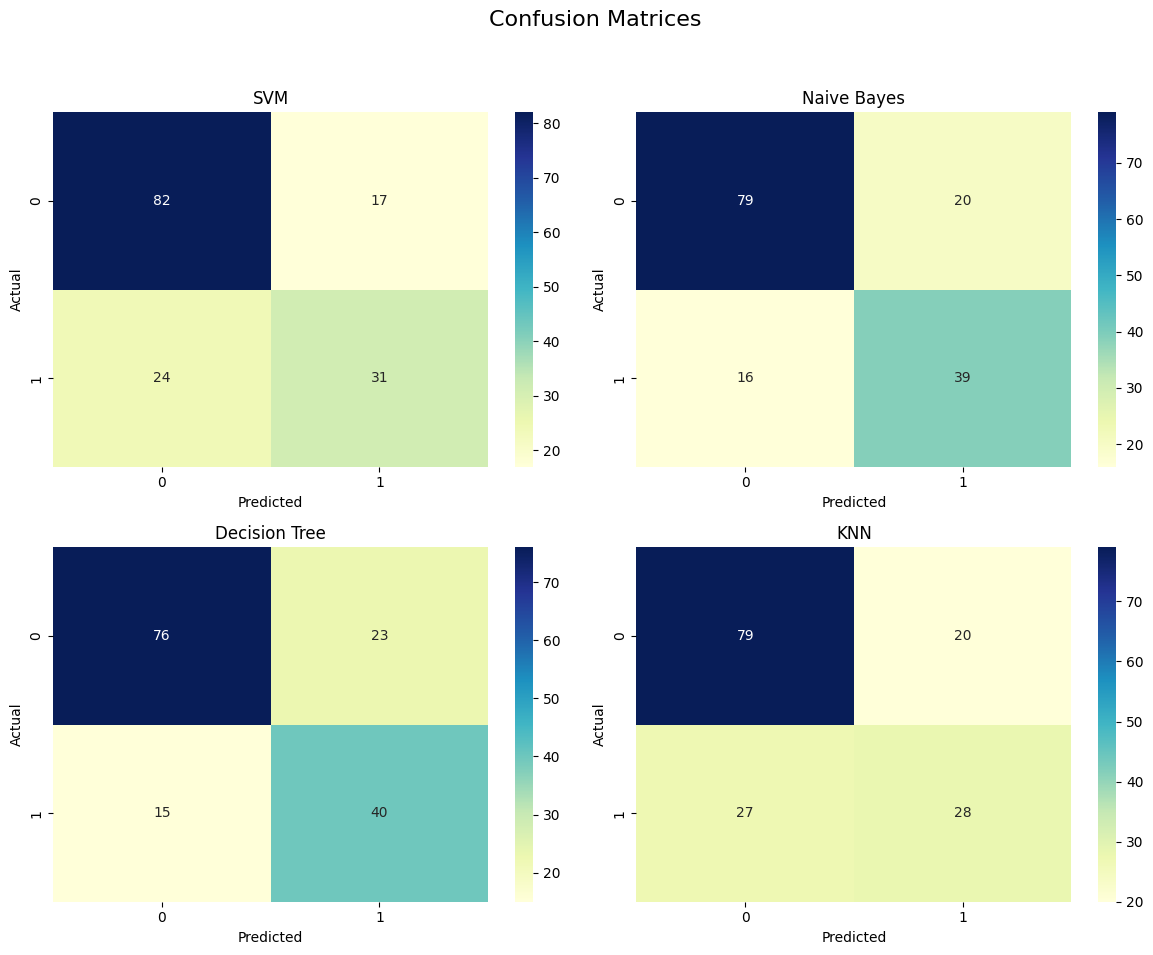

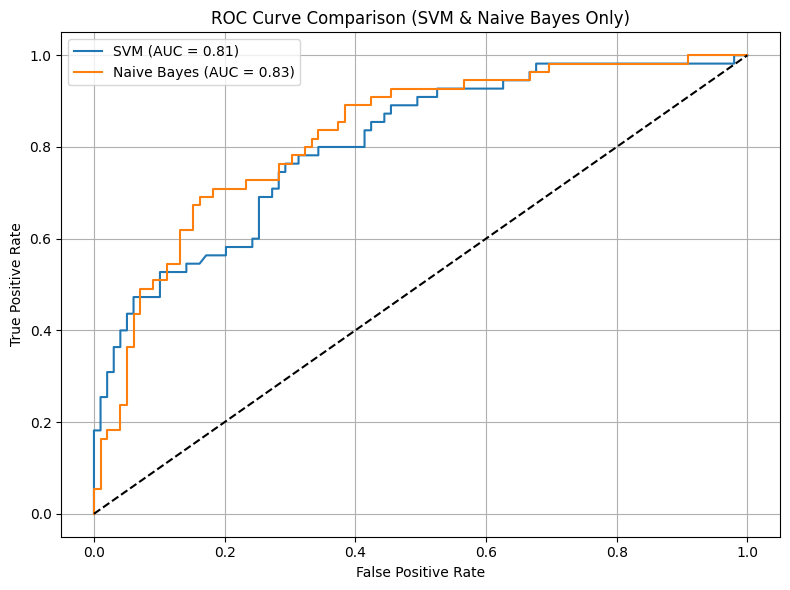

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix, roc_curve, auc
    )
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load dataset
df = pd.read_csv('pima-indians-diabetes.data.csv', header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models to evaluate
models = {
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Conf Matrix": confusion_matrix(y_test, y_pred),
        "ROC": roc_curve(y_test, y_prob),
        "AUC": auc(*roc_curve(y_test, y_prob)[:2])
    })

# Display performance table
summary = pd.DataFrame([{k: v for k, v in r.items() if k not in ['Conf Matrix', 'ROC']} for r in results])
summary.set_index('Model', inplace=True)
print("\n Performance Metrics:")
print(summary.round(4))

# Plot Confusion Matrices
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for i, r in enumerate(results):
    sns.heatmap(r['Conf Matrix'], annot=True, fmt='d', cmap='YlGnBu', ax=axs[i])
    axs[i].set_title(f"{r['Model']}")
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("Actual")
plt.suptitle("Confusion Matrices", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot ROC Curves (Only for SVM and Naive Bayes)
plt.figure(figsize=(8,6))
for r in results:
    if r['Model'] in ['SVM', 'Naive Bayes']:
        fpr, tpr, _ = r['ROC']
        plt.plot(fpr, tpr, label=f"{r['Model']} (AUC = {r['AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison (SVM & Naive Bayes Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




 Performance Metrics:
               Accuracy  Recall  Precision  F1 Score     AUC
Model                                                       
SVM              0.7403  0.5455     0.6667    0.6000  0.7985
Naive Bayes      0.7922  0.6909     0.7170    0.7037  0.8281
Decision Tree    0.7338  0.6545     0.6207    0.6372  0.7162
KNN              0.6948  0.4364     0.6000    0.5053  0.7530


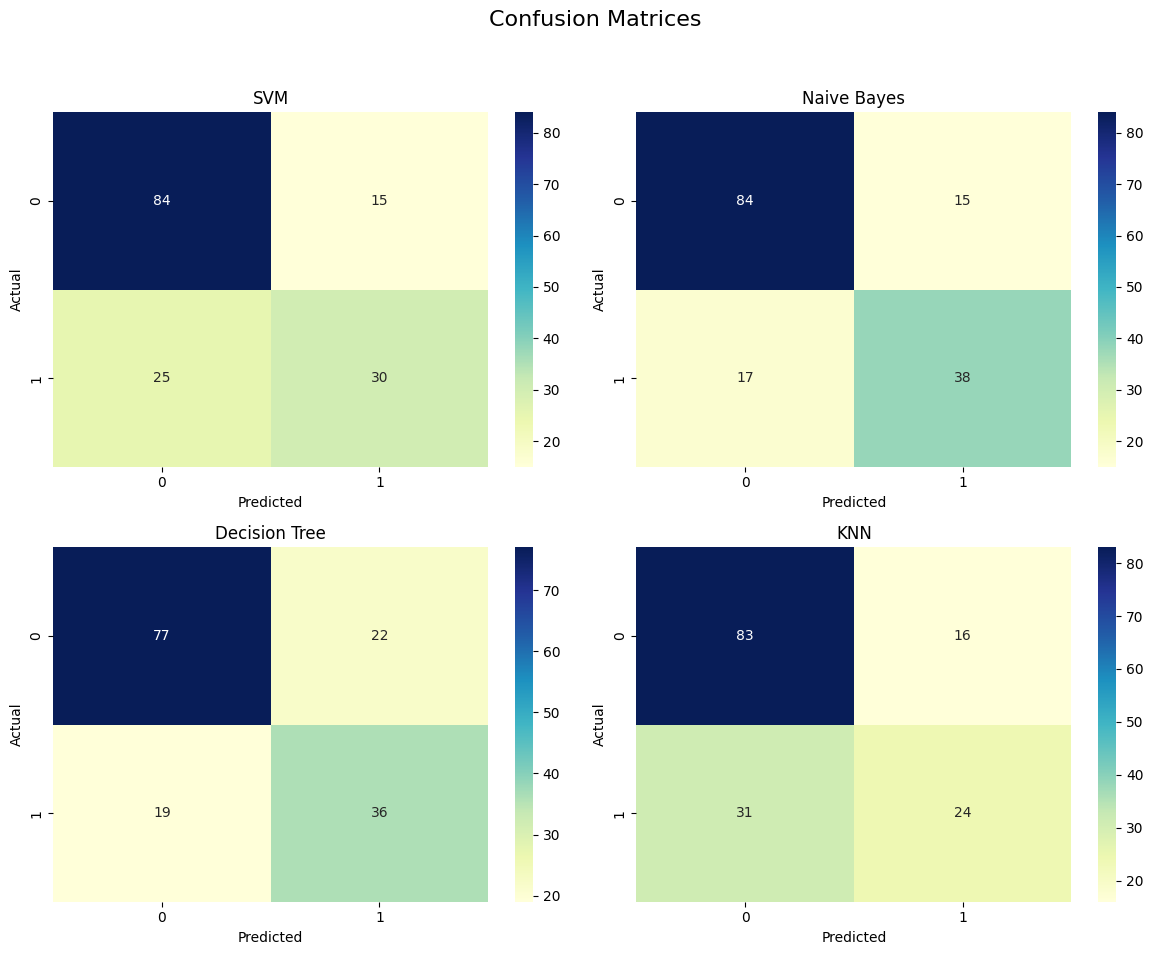

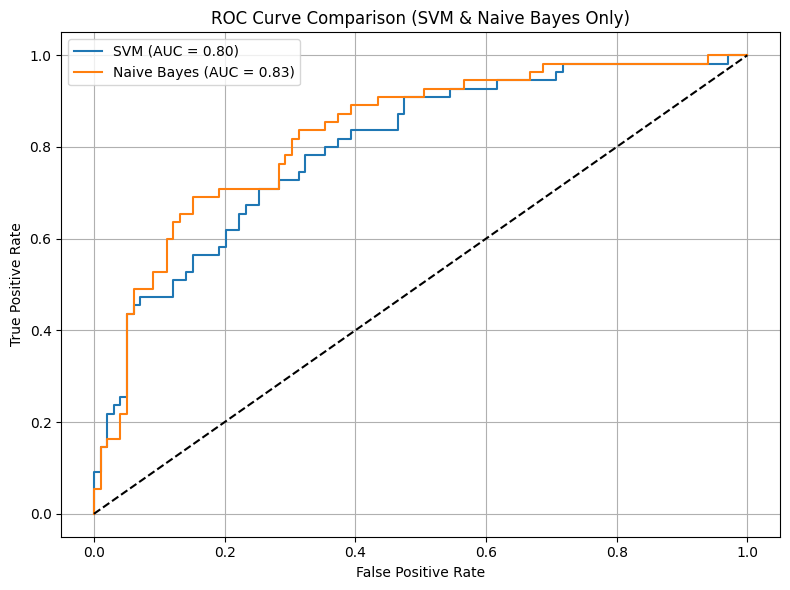

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load dataset
df = pd.read_csv('pima-indians-diabetes.data.csv', header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Models to evaluate
models = {
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Conf Matrix": confusion_matrix(y_test, y_pred),
        "ROC": roc_curve(y_test, y_prob),
        "AUC": auc(*roc_curve(y_test, y_prob)[:2])
    })

# Display performance table
summary = pd.DataFrame([{k: v for k, v in r.items() if k not in ['Conf Matrix', 'ROC']} for r in results])
summary.set_index('Model', inplace=True)
print("\n Performance Metrics:")
print(summary.round(4))

# Plot Confusion Matrices
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for i, r in enumerate(results):
    sns.heatmap(r['Conf Matrix'], annot=True, fmt='d', cmap='YlGnBu', ax=axs[i])
    axs[i].set_title(f"{r['Model']}")
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("Actual")
plt.suptitle("Confusion Matrices", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot ROC Curves (Only for SVM and Naive Bayes)
plt.figure(figsize=(8,6))
for r in results:
    if r['Model'] in ['SVM', 'Naive Bayes']:
        fpr, tpr, _ = r['ROC']
        plt.plot(fpr, tpr, label=f"{r['Model']} (AUC = {r['AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison (SVM & Naive Bayes Only)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



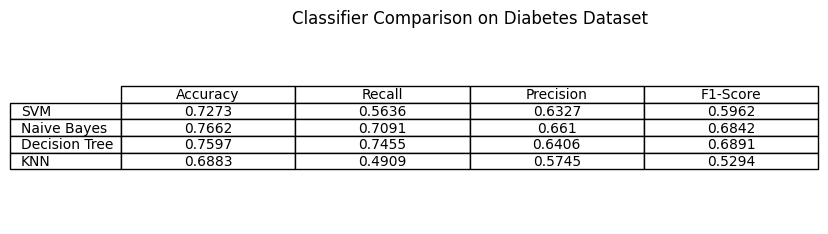

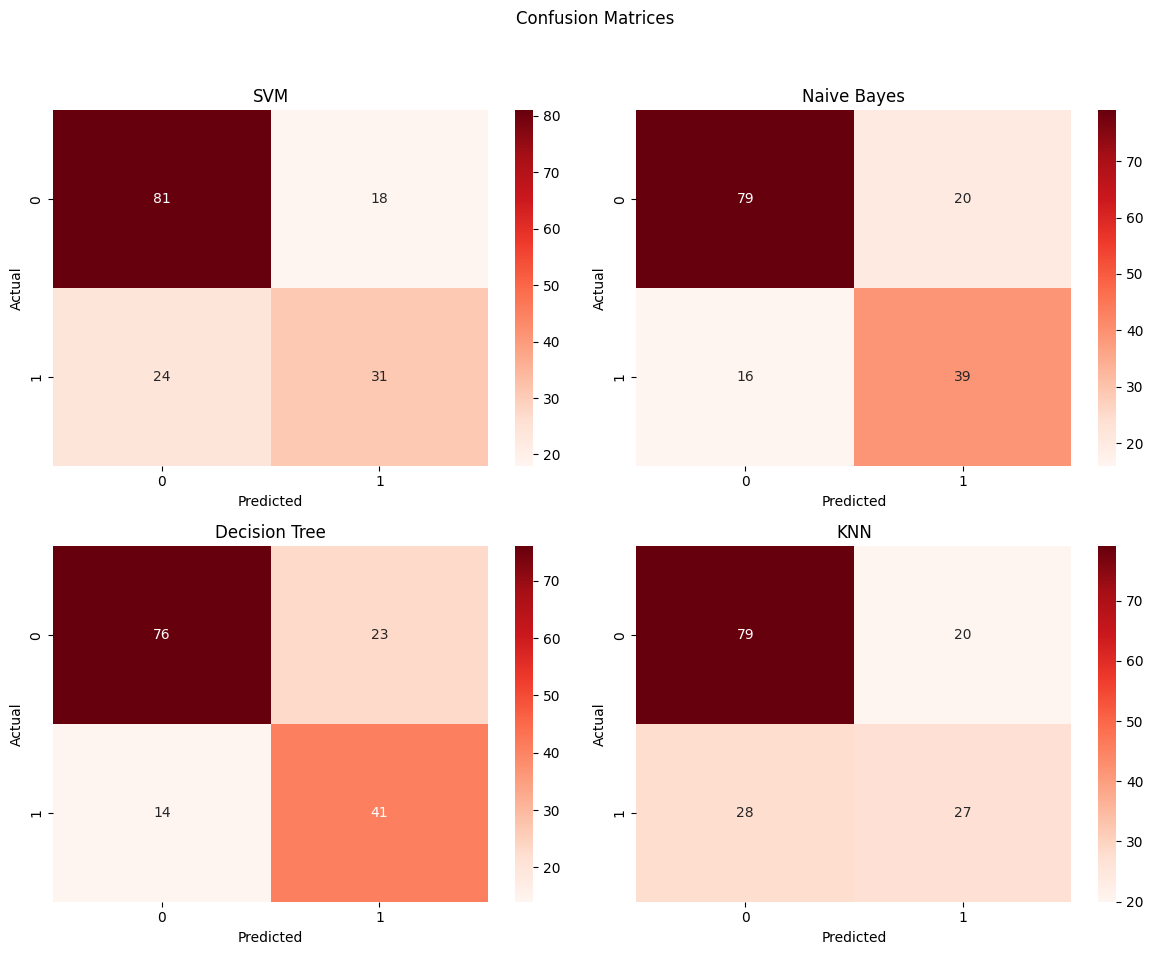

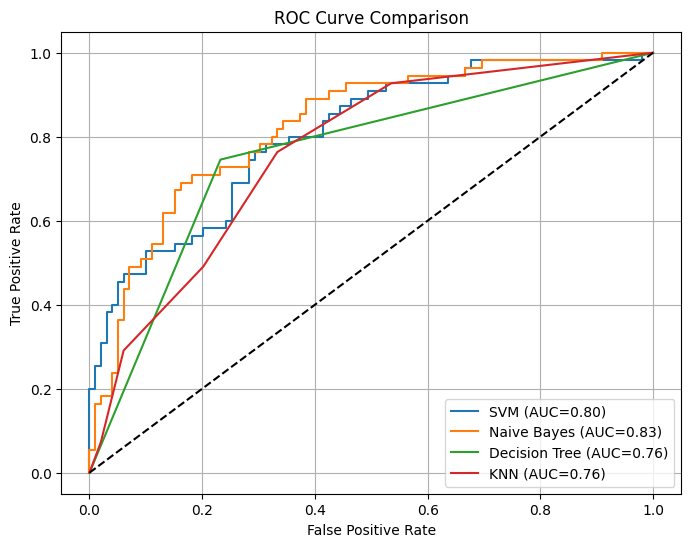

In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, confusion_matrix, roc_curve, auc)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load dataset
df = pd.read_csv('pima-indians-diabetes.data.csv', header=None)
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.2, random_state=42)

# Models
models = {
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

results, confs, rocs = {}, {}, {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results[name] = [
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ]
    confs[name] = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    rocs[name] = (fpr, tpr, auc(fpr, tpr))

# Metrics table
metrics_df = pd.DataFrame(results, index=['Accuracy', 'Recall', 'Precision', 'F1-Score']).T.round(4)
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.axis('off')
t = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
             rowLabels=metrics_df.index, loc='center', cellLoc='center')
t.auto_set_font_size(False); t.set_fontsize(10)
plt.title("Classifier Comparison on Diabetes Dataset")
plt.savefig("diabetes_metrics_table.png", dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix Heatmaps
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for i, (name, cm) in enumerate(confs.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axs[i])
    axs[i].set_title(name); axs[i].set_xlabel('Predicted'); axs[i].set_ylabel('Actual')
plt.suptitle("Confusion Matrices")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("diabetes_confusion_matrices.png", dpi=300)
plt.show()

# ROC Curve
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc_val) in rocs.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.grid(True)
plt.savefig("diabetes_roc_comparison.png", dpi=300)
plt.show()
